In [23]:
from tools.utils import *
from tools.hom_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [24]:
# Random
seed = 42

# Model
hidden_channels_list = [32, 64, 128, 256, 512]
# hidden_channels = 128 varying
num_classes = 6
num_layers = 2
aggr='mean'
dropout = 0.5
use_skip_connections = True

# Training
batch_size = 32
epochs = 30
decay = 1e-4
lr = 1e-4
maxlr = 3e-4

# Experiments iteration
i = 0

# Preprocess

In [25]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [26]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [27]:
# Create splits
labels = [data.y.item() for data in normalized_hom_dataset_attr]

train_set, temp_set = train_test_split(
    normalized_hom_dataset_attr, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 32 hidden_channels GraphConv

Epoch 1/30
Train Loss: 1.8060 | Validation Loss: 1.8021
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0843 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.8092 | Validation Loss: 1.8018
Train Acc: 0.1405 | Validation Acc: 0.1667
Train F1: 0.0720 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.8074 | Validation Loss: 1.8014
Train Acc: 0.1500 | Validation Acc: 0.1667
Train F1: 0.0730 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.8029 | Validation Loss: 1.8008
Train Acc: 0.1810 | Validation Acc: 0.1667
Train F1: 0.1180 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.8037 | Validation Loss: 1.7996
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.1074 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.8049 | Validation Loss: 1.7986
Train Acc: 0.1500 | Validation Acc: 0.1667
Train F1: 0.0929 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7969 | Validation Loss: 1.7973
Train Acc: 0.1929 | Validation Acc: 0.1556
Train F1: 0.1312 | Validation F1: 0.0449

Epoch 8/30
Tr

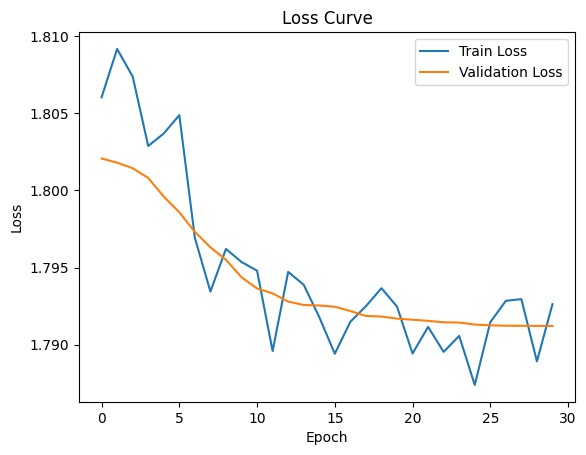

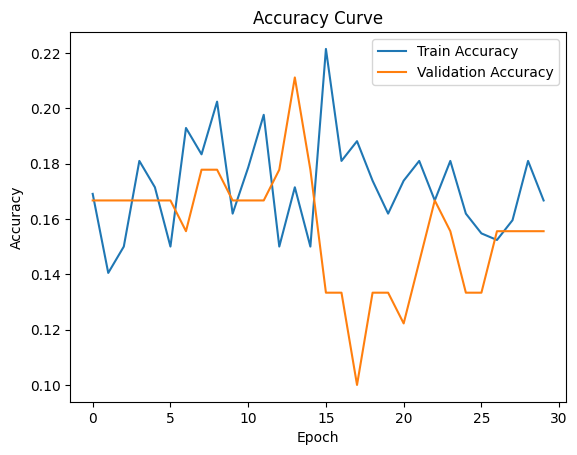

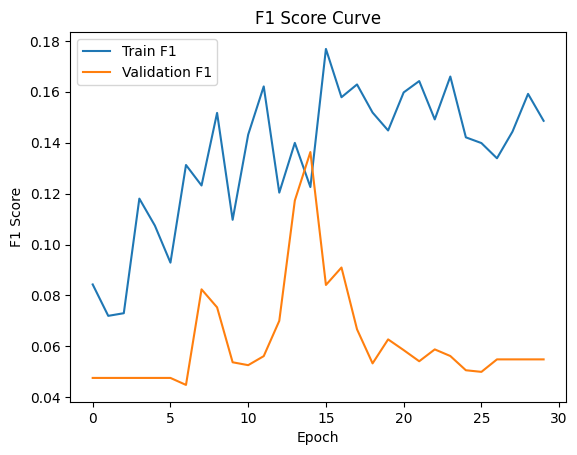

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8060,1.8021,0.1690,0.1667,0.0843,0.0476
1,2,1.8092,1.8018,0.1405,0.1667,0.0720,0.0476
2,3,1.8074,1.8014,0.1500,0.1667,0.0730,0.0476
3,4,1.8029,1.8008,0.1810,0.1667,0.1180,0.0476
4,5,1.8037,1.7996,0.1714,0.1667,0.1074,0.0476
5,6,1.8049,1.7986,0.1500,0.1667,0.0929,0.0476
6,7,1.7969,1.7973,0.1929,0.1556,0.1312,0.0449
7,8,1.7934,1.7963,0.1833,0.1778,0.1232,0.0824
8,9,1.7962,1.7955,0.2024,0.1778,0.1517,0.0753
9,10,1.7954,1.7944,0.1619,0.1667,0.1097,0.0538


In [28]:
hidden_channels = hidden_channels_list[i]
i += 1

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 64 hidden_channels GraphConv

Epoch 1/30
Train Loss: 1.8094 | Validation Loss: 1.8038
Train Acc: 0.1857 | Validation Acc: 0.1667
Train F1: 0.0935 | Validation F1: 0.0481

Epoch 2/30
Train Loss: 1.8039 | Validation Loss: 1.8031
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.0931 | Validation F1: 0.0481

Epoch 3/30
Train Loss: 1.8044 | Validation Loss: 1.8013
Train Acc: 0.1762 | Validation Acc: 0.1667
Train F1: 0.0894 | Validation F1: 0.0481

Epoch 4/30
Train Loss: 1.8023 | Validation Loss: 1.7994
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.0880 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7980 | Validation Loss: 1.7972
Train Acc: 0.1452 | Validation Acc: 0.1667
Train F1: 0.0760 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7978 | Validation Loss: 1.7946
Train Acc: 0.1905 | Validation Acc: 0.1667
Train F1: 0.0959 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7932 | Validation Loss: 1.7933
Train Acc: 0.1500 | Validation Acc: 0.1667
Train F1: 0.0794 | Validation F1: 0.0476

Epoch 8/30
Tr

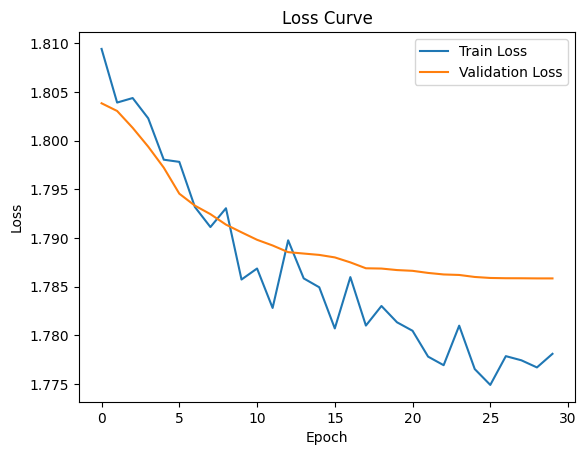

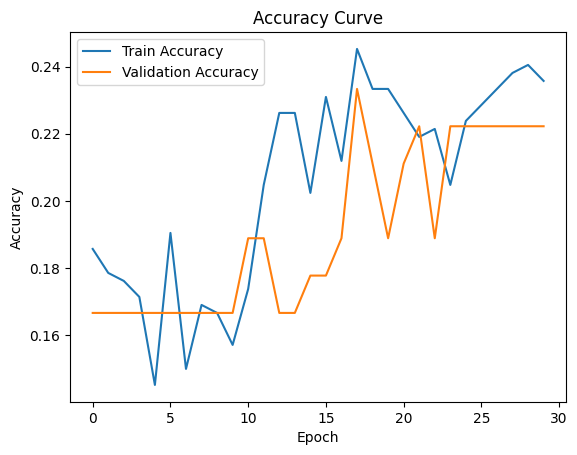

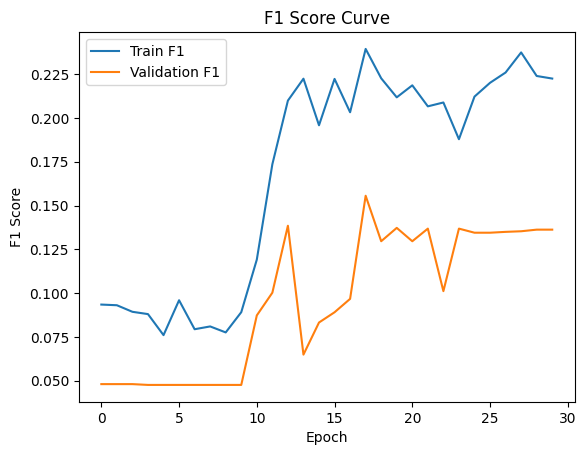

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8094,1.8038,0.1857,0.1667,0.0935,0.0481
1,2,1.8039,1.8031,0.1786,0.1667,0.0931,0.0481
2,3,1.8044,1.8013,0.1762,0.1667,0.0894,0.0481
3,4,1.8023,1.7994,0.1714,0.1667,0.0880,0.0476
4,5,1.7980,1.7972,0.1452,0.1667,0.0760,0.0476
5,6,1.7978,1.7946,0.1905,0.1667,0.0959,0.0476
6,7,1.7932,1.7933,0.1500,0.1667,0.0794,0.0476
7,8,1.7911,1.7925,0.1690,0.1667,0.0810,0.0476
8,9,1.7931,1.7914,0.1667,0.1667,0.0776,0.0476
9,10,1.7857,1.7906,0.1571,0.1667,0.0891,0.0476


In [29]:
hidden_channels = hidden_channels_list[i]
i += 1

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 128 hidden_channels GraphConv

Epoch 1/30
Train Loss: 1.8053 | Validation Loss: 1.7994
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0686 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.8043 | Validation Loss: 1.7978
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.0786 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.8004 | Validation Loss: 1.7951
Train Acc: 0.1667 | Validation Acc: 0.1889
Train F1: 0.0788 | Validation F1: 0.0861

Epoch 4/30
Train Loss: 1.7962 | Validation Loss: 1.7923
Train Acc: 0.1643 | Validation Acc: 0.1778
Train F1: 0.0844 | Validation F1: 0.0910

Epoch 5/30
Train Loss: 1.7949 | Validation Loss: 1.7904
Train Acc: 0.1762 | Validation Acc: 0.1556
Train F1: 0.1079 | Validation F1: 0.0458

Epoch 6/30
Train Loss: 1.7903 | Validation Loss: 1.7896
Train Acc: 0.1762 | Validation Acc: 0.1778
Train F1: 0.1400 | Validation F1: 0.1017

Epoch 7/30
Train Loss: 1.7907 | Validation Loss: 1.7894
Train Acc: 0.1857 | Validation Acc: 0.1556
Train F1: 0.1407 | Validation F1: 0.0462

Epoch 8/30
Tr

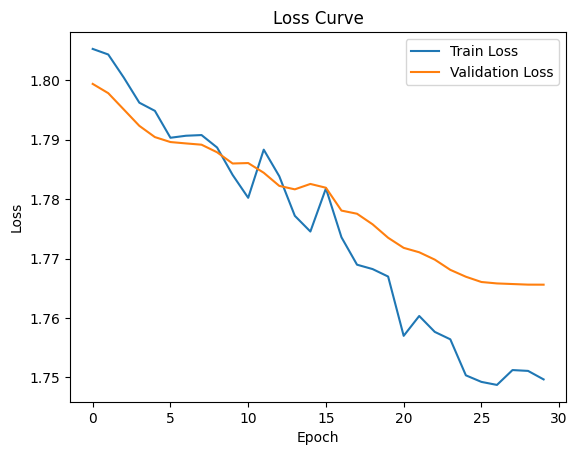

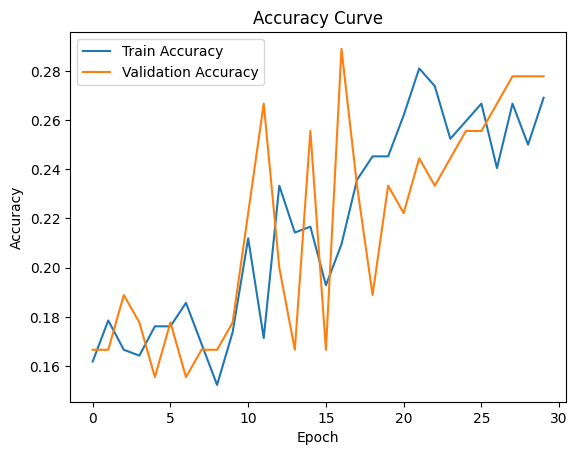

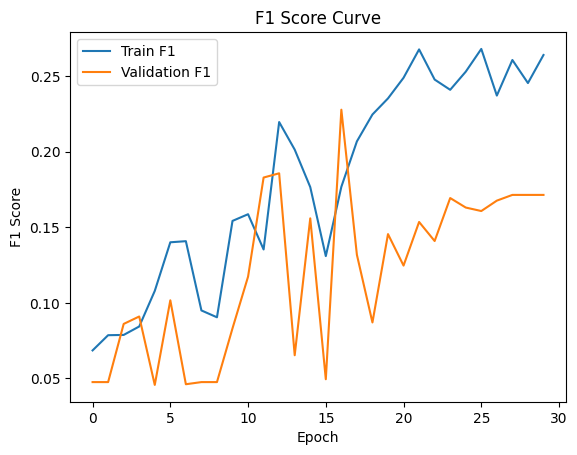

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8053,1.7994,0.1619,0.1667,0.0686,0.0476
1,2,1.8043,1.7978,0.1786,0.1667,0.0786,0.0476
2,3,1.8004,1.7951,0.1667,0.1889,0.0788,0.0861
3,4,1.7962,1.7923,0.1643,0.1778,0.0844,0.0910
4,5,1.7949,1.7904,0.1762,0.1556,0.1079,0.0458
5,6,1.7903,1.7896,0.1762,0.1778,0.1400,0.1017
6,7,1.7907,1.7894,0.1857,0.1556,0.1407,0.0462
7,8,1.7908,1.7892,0.1690,0.1667,0.0950,0.0476
8,9,1.7887,1.7879,0.1524,0.1667,0.0904,0.0476
9,10,1.7841,1.7860,0.1738,0.1778,0.1541,0.0832


In [30]:
hidden_channels = hidden_channels_list[i]
i += 1

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 256 hidden_channels GraphConv

Epoch 1/30
Train Loss: 1.7941 | Validation Loss: 1.7921
Train Acc: 0.1905 | Validation Acc: 0.1778
Train F1: 0.1392 | Validation F1: 0.1345

Epoch 2/30
Train Loss: 1.7971 | Validation Loss: 1.7914
Train Acc: 0.1381 | Validation Acc: 0.1556
Train F1: 0.1036 | Validation F1: 0.0746

Epoch 3/30
Train Loss: 1.7944 | Validation Loss: 1.7908
Train Acc: 0.1571 | Validation Acc: 0.1667
Train F1: 0.1448 | Validation F1: 0.0835

Epoch 4/30
Train Loss: 1.7937 | Validation Loss: 1.7906
Train Acc: 0.1762 | Validation Acc: 0.1556
Train F1: 0.1428 | Validation F1: 0.0453

Epoch 5/30
Train Loss: 1.7951 | Validation Loss: 1.7893
Train Acc: 0.1595 | Validation Acc: 0.2111
Train F1: 0.1189 | Validation F1: 0.1045

Epoch 6/30
Train Loss: 1.7882 | Validation Loss: 1.7897
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.1397 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7902 | Validation Loss: 1.7877
Train Acc: 0.1929 | Validation Acc: 0.2444
Train F1: 0.1408 | Validation F1: 0.1691

Epoch 8/30
Tr

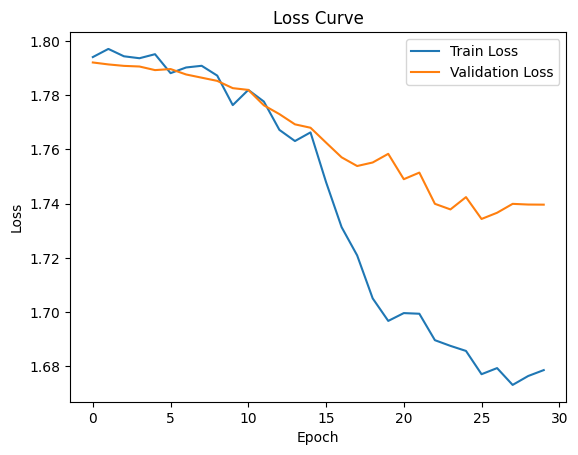

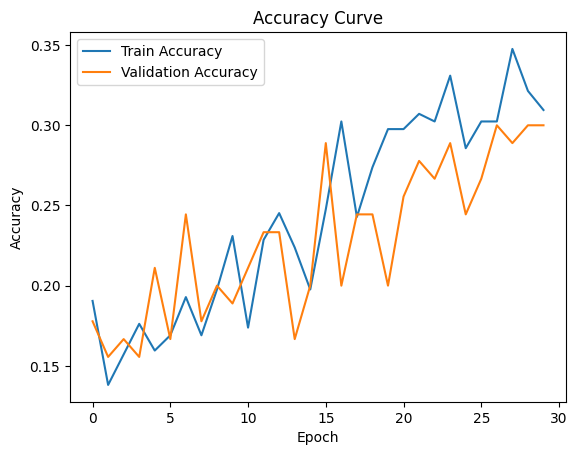

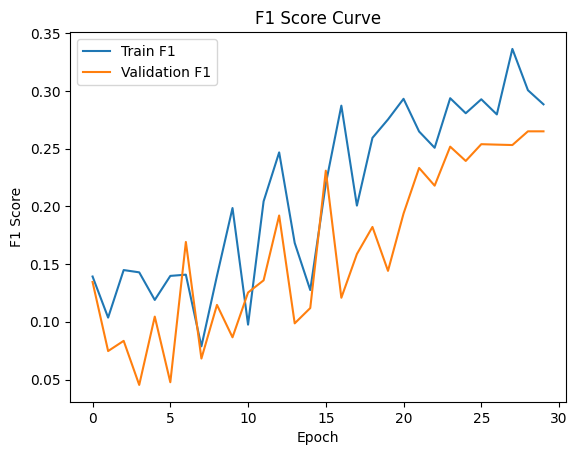

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7941,1.7921,0.1905,0.1778,0.1392,0.1345
1,2,1.7971,1.7914,0.1381,0.1556,0.1036,0.0746
2,3,1.7944,1.7908,0.1571,0.1667,0.1448,0.0835
3,4,1.7937,1.7906,0.1762,0.1556,0.1428,0.0453
4,5,1.7951,1.7893,0.1595,0.2111,0.1189,0.1045
5,6,1.7882,1.7897,0.1690,0.1667,0.1397,0.0476
6,7,1.7902,1.7877,0.1929,0.2444,0.1408,0.1691
7,8,1.7909,1.7865,0.1690,0.1778,0.0787,0.0682
8,9,1.7873,1.7853,0.1976,0.2000,0.1397,0.1146
9,10,1.7764,1.7826,0.2310,0.1889,0.1985,0.0865


In [31]:
hidden_channels = hidden_channels_list[i]
i += 1

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 512 hidden_channels GraphConv

Epoch 1/30
Train Loss: 1.8000 | Validation Loss: 1.7947
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7969 | Validation Loss: 1.7927
Train Acc: 0.1571 | Validation Acc: 0.1667
Train F1: 0.0762 | Validation F1: 0.0481

Epoch 3/30
Train Loss: 1.7942 | Validation Loss: 1.7932
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.1246 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7916 | Validation Loss: 1.7924
Train Acc: 0.1881 | Validation Acc: 0.2333
Train F1: 0.1137 | Validation F1: 0.1370

Epoch 5/30
Train Loss: 1.7876 | Validation Loss: 1.7879
Train Acc: 0.2119 | Validation Acc: 0.1667
Train F1: 0.1621 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7884 | Validation Loss: 1.7853
Train Acc: 0.2071 | Validation Acc: 0.1889
Train F1: 0.1322 | Validation F1: 0.0895

Epoch 7/30
Train Loss: 1.7835 | Validation Loss: 1.7812
Train Acc: 0.2262 | Validation Acc: 0.1778
Train F1: 0.1848 | Validation F1: 0.0682

Epoch 8/30
Tr

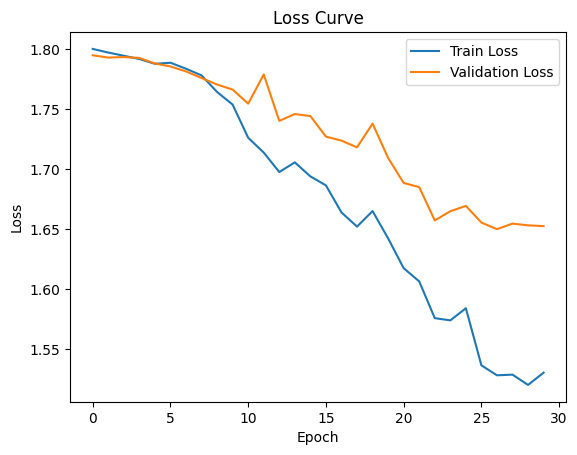

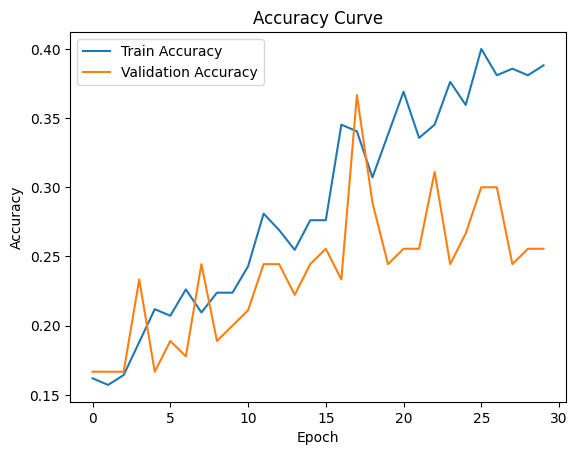

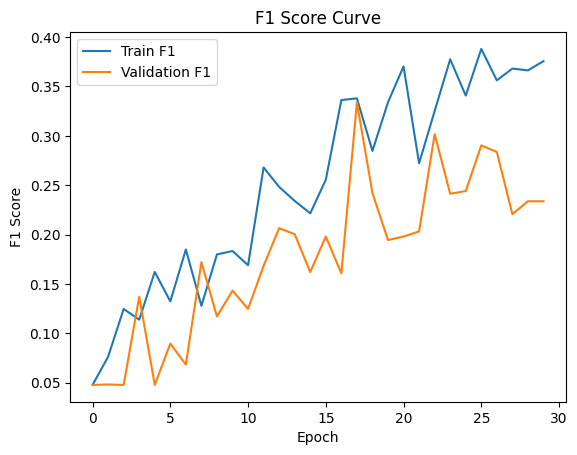

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8000,1.7947,0.1619,0.1667,0.0476,0.0476
1,2,1.7969,1.7927,0.1571,0.1667,0.0762,0.0481
2,3,1.7942,1.7932,0.1643,0.1667,0.1246,0.0476
3,4,1.7916,1.7924,0.1881,0.2333,0.1137,0.1370
4,5,1.7876,1.7879,0.2119,0.1667,0.1621,0.0476
5,6,1.7884,1.7853,0.2071,0.1889,0.1322,0.0895
6,7,1.7835,1.7812,0.2262,0.1778,0.1848,0.0682
7,8,1.7779,1.7757,0.2095,0.2444,0.1277,0.1720
8,9,1.7641,1.7703,0.2238,0.1889,0.1798,0.1170
9,10,1.7535,1.7661,0.2238,0.2000,0.1833,0.1431


In [32]:
hidden_channels = hidden_channels_list[i]
i += 1

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)